In [83]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-12-2022)


In [84]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset , Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints
from gammapy.estimators import  FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

{'path': '/home/katrin/Documents', 'path_crab': '/home/katrin/Documents/Crab'}
spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : OnfLwa20 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralM

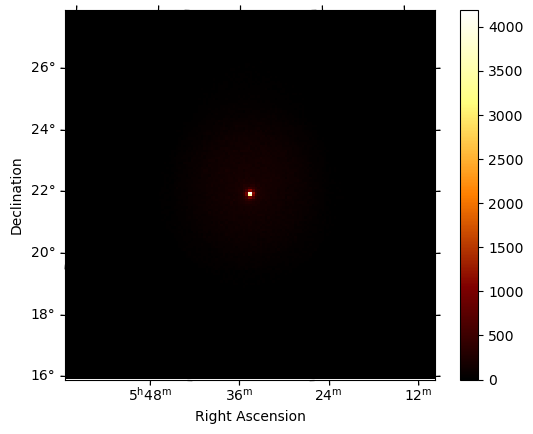

In [85]:
import json
with open("config.json") as json_data_file:
    config = json.load(json_data_file)
config = config['local']
print(config)
source = 'Crab'
path = config["path"]
path_crab = config["path_crab"]

models = Models.read(f"{path_crab}/standard_model.yml")
dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)

model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [86]:
savefig = False
picformat = 'svg'
shift = 0.1
tilt = 0.015


In [110]:
shift_rnds = np.append(infos[:N_max,0] ,infos_old[:N_max,0])

shift_rnds

array([-0.08098922,  0.05668394, -0.16437677,  0.00674353, -0.01689944,
       -0.17243089, -0.11196547, -0.09171303,  0.13313183,  0.00513277,
        0.19396179, -0.03486193, -0.15502297, -0.01062915,  0.03304997,
        0.17661608, -0.10369274,  0.01033589,  0.0373955 , -0.13057002,
       -0.03806689, -0.02521479,  0.08948348,  0.15487977, -0.07904964,
       -0.02118321, -0.00792549, -0.24406446,  0.19680122,  0.06211956,
        0.13487492,  0.00079635,  0.08508073,  0.15982633,  0.03846026,
        0.11285931,  0.07297825, -0.01970418,  0.02072098, -0.05589546,
        0.07097926,  0.08709677])

In [113]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")

infos_old = np.loadtxt("data/7a_P_draw_info_old.txt")
pars_old = np.loadtxt("data/7a_P_draw_par_old.txt")
flux_old = np.loadtxt("data/7a_P_draw_flux_old.txt")
flux2e_old = np.loadtxt("data/7a_P_draw_flux2e_old.txt")


lem = len(infos) + len(infos_old)
N_max = 2001
N = np.min([lem, N_max])

print(N)
shift_rnds_old = infos_old[:N_max,0]

shift_rnds = np.append(infos[:N_max,0] , infos_old[:N_max,0] )
index_rnds = np.append(infos[:N_max,1], infos_old[:N_max,1])
stat_sums = np.append(infos[:N_max,2], infos_old[:N_max,2])


#amplitude', 'index', 'norm', 'tilt
amplitudes = np.append(pars[:N_max,0:2] , pars_old[:N_max,0:2] )
indices = np.append(pars[:N_max,2:4] , pars_old[:N_max,2:4] )
norms = np.append(pars[:N_max,4:6], pars_old[:N_max,4:6])
tilts = np.append(pars[:N_max,6:8], pars_old[:N_max,6:8])


fluxpoints = []
for f in shift_rnds:
    try:
        print(f'6_fluxpoints_{f:.6}')
        ff = FluxPoints.read(f'data/fluxpoints/6_fluxpoints_{f:.6}.fits') 
        fluxpoints.append(ff)
        
    except:
        pass
    
for f in shift_rnds_old:
    try:
        print(f'6_fluxpoints_{f:.6}')
        ff = FluxPoints.read(f'data/fluxpoints_old/6_fluxpoints_{f:.6}.fits') 
        fluxpoints.append(ff)
        
    except:
        pass    

print(len(fluxpoints), len(shift_rnds))    
N = len(fluxpoints)

2000
6_fluxpoints_-0.0809892
6_fluxpoints_0.0566839
6_fluxpoints_-0.164377
6_fluxpoints_0.00674353
6_fluxpoints_-0.0168994
6_fluxpoints_-0.172431
6_fluxpoints_-0.111965
6_fluxpoints_-0.091713
6_fluxpoints_0.133132
6_fluxpoints_0.00513277
6_fluxpoints_0.193962
6_fluxpoints_-0.0348619
6_fluxpoints_-0.155023
6_fluxpoints_-0.0106292
6_fluxpoints_0.03305
6_fluxpoints_0.176616
6_fluxpoints_-0.103693
6_fluxpoints_0.0103359
6_fluxpoints_0.0373955
6_fluxpoints_-0.13057
6_fluxpoints_-0.0380669
6_fluxpoints_0.00418853
6_fluxpoints_0.0286265
6_fluxpoints_0.00424686
6_fluxpoints_0.068656
6_fluxpoints_0.00528823
6_fluxpoints_0.0189018
6_fluxpoints_0.0038637
6_fluxpoints_0.120031
6_fluxpoints_-0.045878
6_fluxpoints_0.0428905
6_fluxpoints_-0.101174
6_fluxpoints_-0.0223038
6_fluxpoints_-0.0610732
6_fluxpoints_0.116815
6_fluxpoints_0.0862917
6_fluxpoints_-0.0791073
6_fluxpoints_0.0810438
6_fluxpoints_0.044463
6_fluxpoints_-0.0042852
6_fluxpoints_0.170316
6_fluxpoints_-0.0105558
6_fluxpoints_-0.0293196
6

6_fluxpoints_-0.0270545
6_fluxpoints_0.152123
6_fluxpoints_0.0721695
6_fluxpoints_-0.0640053
6_fluxpoints_0.107998
6_fluxpoints_0.38076
6_fluxpoints_0.0116713
6_fluxpoints_-0.10485
6_fluxpoints_0.0367565
6_fluxpoints_-0.0420503
6_fluxpoints_-0.0504498
6_fluxpoints_-0.14442
6_fluxpoints_0.00999177
6_fluxpoints_0.126032
6_fluxpoints_-0.0705892
6_fluxpoints_-0.0487013
6_fluxpoints_-0.117848
6_fluxpoints_0.108722
6_fluxpoints_0.0594437
6_fluxpoints_0.0392267
6_fluxpoints_0.09237
6_fluxpoints_-0.0749654
6_fluxpoints_-0.0953993
6_fluxpoints_-0.0647957
6_fluxpoints_-0.0106928
6_fluxpoints_-0.141698
6_fluxpoints_-0.0472949
6_fluxpoints_-0.102238
6_fluxpoints_0.141285
6_fluxpoints_0.0233279
6_fluxpoints_0.0152787
6_fluxpoints_0.117815
6_fluxpoints_-0.0352435
6_fluxpoints_0.0690879
6_fluxpoints_0.255203
6_fluxpoints_0.111841
6_fluxpoints_0.0266074
6_fluxpoints_0.0272961
6_fluxpoints_0.282278
6_fluxpoints_0.162376
6_fluxpoints_0.0116461
6_fluxpoints_0.0708044
6_fluxpoints_0.0886832
6_fluxpoints_0

6_fluxpoints_-0.0292163
6_fluxpoints_-0.0177512
6_fluxpoints_0.087885
6_fluxpoints_-0.0963437
6_fluxpoints_0.0224871
6_fluxpoints_-0.158795
6_fluxpoints_-0.115648
6_fluxpoints_0.0725031
6_fluxpoints_0.0514661
6_fluxpoints_-0.0416175
6_fluxpoints_0.0570964
6_fluxpoints_0.0541819
6_fluxpoints_-0.120651
6_fluxpoints_-0.0492334
6_fluxpoints_0.0517762
6_fluxpoints_-0.27691
6_fluxpoints_-0.0202445
6_fluxpoints_-0.0484545
6_fluxpoints_-0.0446174
6_fluxpoints_-0.0622795
6_fluxpoints_-0.103758
6_fluxpoints_0.163945
6_fluxpoints_0.00624753
6_fluxpoints_0.0733547
6_fluxpoints_-0.038846
6_fluxpoints_0.000768878
6_fluxpoints_0.0414901
6_fluxpoints_-0.00440472
6_fluxpoints_-0.15665
6_fluxpoints_-0.0461846
6_fluxpoints_-0.0429966
6_fluxpoints_-0.049052
6_fluxpoints_-0.102668
6_fluxpoints_0.01656
6_fluxpoints_-0.0386366
6_fluxpoints_-0.0239894
6_fluxpoints_-0.145852
6_fluxpoints_-0.0886764
6_fluxpoints_0.0796956
6_fluxpoints_-0.00165663
6_fluxpoints_0.0635052
6_fluxpoints_0.0734043
6_fluxpoints_-0.017

6_fluxpoints_0.0517482
6_fluxpoints_0.100918
6_fluxpoints_-0.216509
6_fluxpoints_0.126036
6_fluxpoints_0.0419297
6_fluxpoints_-0.03885
6_fluxpoints_0.216515
6_fluxpoints_0.158512
6_fluxpoints_-0.0840467
6_fluxpoints_0.171002
6_fluxpoints_0.0887794
6_fluxpoints_-0.0112451
6_fluxpoints_0.0560186
6_fluxpoints_-0.153095
6_fluxpoints_0.0801952
6_fluxpoints_-0.0348667
6_fluxpoints_-0.0382447
6_fluxpoints_-0.137327
6_fluxpoints_0.0253078
6_fluxpoints_-0.135359
6_fluxpoints_0.117837
6_fluxpoints_0.00557619
6_fluxpoints_-0.0938954
6_fluxpoints_0.102206
6_fluxpoints_-0.226272
6_fluxpoints_-0.305069
6_fluxpoints_0.113852
6_fluxpoints_0.165807
6_fluxpoints_0.0164755
6_fluxpoints_0.00184697
6_fluxpoints_-0.114544
6_fluxpoints_0.124178
6_fluxpoints_-0.0767341
6_fluxpoints_-0.130239
6_fluxpoints_0.0356103
6_fluxpoints_-0.150461
6_fluxpoints_-0.0931976
6_fluxpoints_0.114576
6_fluxpoints_0.158121
6_fluxpoints_-0.0165085
6_fluxpoints_0.0611307
6_fluxpoints_-0.0811283
6_fluxpoints_0.0882487
6_fluxpoints_

6_fluxpoints_0.159826
6_fluxpoints_0.0384603
6_fluxpoints_0.112859
6_fluxpoints_0.0729783
6_fluxpoints_-0.0197042
6_fluxpoints_0.020721
6_fluxpoints_-0.0558955
6_fluxpoints_0.0709793
6_fluxpoints_0.0870968
6_fluxpoints_-0.00742682
6_fluxpoints_-0.00295389
6_fluxpoints_-0.0621819
6_fluxpoints_0.0908538
6_fluxpoints_0.165448
6_fluxpoints_0.104699
6_fluxpoints_-0.0518694
6_fluxpoints_-0.113807
6_fluxpoints_0.016443
6_fluxpoints_-0.0805415
6_fluxpoints_-0.0741444
6_fluxpoints_-0.00459613
6_fluxpoints_0.028908
6_fluxpoints_-0.116688
6_fluxpoints_-0.20933
6_fluxpoints_0.165409
6_fluxpoints_0.248887
6_fluxpoints_-0.15672
6_fluxpoints_-0.0381893
6_fluxpoints_-0.104526
6_fluxpoints_-0.152262
6_fluxpoints_0.0558682
6_fluxpoints_-0.0209423
6_fluxpoints_0.0210325
6_fluxpoints_0.119039
6_fluxpoints_0.115328
6_fluxpoints_-0.0310335
6_fluxpoints_0.0294012
6_fluxpoints_0.115719
6_fluxpoints_-0.0893288
6_fluxpoints_-0.00953106
6_fluxpoints_0.029667
6_fluxpoints_0.0698538
6_fluxpoints_0.023541
6_fluxpoi

6_fluxpoints_-0.011265
6_fluxpoints_0.000805583
6_fluxpoints_0.21249
6_fluxpoints_-0.0600017
6_fluxpoints_0.0921685
6_fluxpoints_0.00935511
6_fluxpoints_-0.0557893
6_fluxpoints_0.119784
6_fluxpoints_-0.117955
6_fluxpoints_-0.0505862
6_fluxpoints_-0.0142448
6_fluxpoints_0.0579364
6_fluxpoints_0.0442353
6_fluxpoints_-0.1711
6_fluxpoints_-0.00931789
6_fluxpoints_0.141946
6_fluxpoints_0.0442045
6_fluxpoints_-0.0128688
6_fluxpoints_0.0657314
6_fluxpoints_0.154917
6_fluxpoints_0.0801773
6_fluxpoints_0.0387322
6_fluxpoints_0.0485903
6_fluxpoints_0.049815
6_fluxpoints_-0.0564404
6_fluxpoints_-0.0676905
6_fluxpoints_-0.14458
6_fluxpoints_-0.146889
6_fluxpoints_-0.0335739
6_fluxpoints_0.203026
6_fluxpoints_-0.0987205
6_fluxpoints_-0.0503573
6_fluxpoints_0.0280253
6_fluxpoints_0.00238664
6_fluxpoints_-0.0195857
6_fluxpoints_-0.0305592
6_fluxpoints_-0.0784756
6_fluxpoints_0.0530011
6_fluxpoints_0.0381831
6_fluxpoints_-0.0390049
6_fluxpoints_0.0154267
6_fluxpoints_0.118473
6_fluxpoints_-0.150855
6_

6_fluxpoints_0.10076
6_fluxpoints_0.0982968
6_fluxpoints_0.191091
6_fluxpoints_-0.0438454
6_fluxpoints_0.30986
6_fluxpoints_-0.00563169
6_fluxpoints_0.157292
6_fluxpoints_0.000446561
6_fluxpoints_0.00879249
6_fluxpoints_0.000907161
6_fluxpoints_0.0225016
6_fluxpoints_-0.00983961
6_fluxpoints_0.102078
6_fluxpoints_-0.00635388
6_fluxpoints_-0.0408513
6_fluxpoints_-0.306913
6_fluxpoints_0.0256622
6_fluxpoints_-0.0130362
6_fluxpoints_0.0118864
6_fluxpoints_-0.111224
6_fluxpoints_0.110396
6_fluxpoints_-0.246026
6_fluxpoints_0.08372
6_fluxpoints_-0.100983
6_fluxpoints_0.0847658
6_fluxpoints_0.00248337
6_fluxpoints_0.0653299
6_fluxpoints_0.00974599
6_fluxpoints_0.02461
6_fluxpoints_-0.031797
6_fluxpoints_-0.133677
6_fluxpoints_-0.107689
6_fluxpoints_0.214474
6_fluxpoints_-0.154886
6_fluxpoints_0.0175397
6_fluxpoints_0.0345437
6_fluxpoints_0.0844795
6_fluxpoints_0.0390608
6_fluxpoints_0.0988524
6_fluxpoints_0.119543
6_fluxpoints_-0.113784
6_fluxpoints_-0.0252813
6_fluxpoints_0.032825
6_fluxpoi

In [114]:
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        rnd = False)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N()
zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/shift**2, 1/tilt**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_asimov])    
result_cor = fit_cor.run([dataset_asimov_N])


In [115]:
dataset_asimov_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_asimov_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [116]:
mask = dataset_asimov.mask.data[:,60,60]
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV

(-0.4866173251816218, 0.4866173251816218)

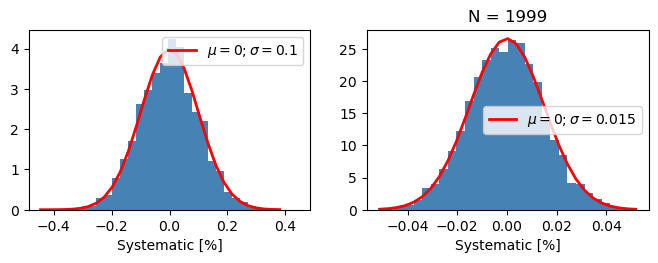

In [117]:
fig, (axs, ax1) = plt.subplots(1,2, figsize = (2*4,7/3))
nbins = 30
count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color = 'steelblue')
sigma =shift
mu = 0
axs.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma}$')

axs.set_xlabel("Systematic [%]")
axs.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)


count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color = 'steelblue')
sigma =tilt
mu = 0
ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma:.3}$')

ax1.set_xlabel("Systematic [%]")
ax1.set_title(f"N = {N}")
ax1.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)



## Compute Asimov Fluxpoints



In [118]:
fluxpoints_asimov_N = FluxPoints.read("data/6_fluxpoints_asimov_N.fits")
fluxpoints_asimov = FluxPoints.read("data/6_fluxpoints_asimov.fits")


In [119]:
energy_edges = dataset_asimov.geoms['geom'].axes[0].edges

In [120]:
def plot_shifted (ff, shift):
    return ff.energy_ref* shift, ff.e2dnde.data[:,0,0],  ff.e2dnde_err.data[:,0,0], 

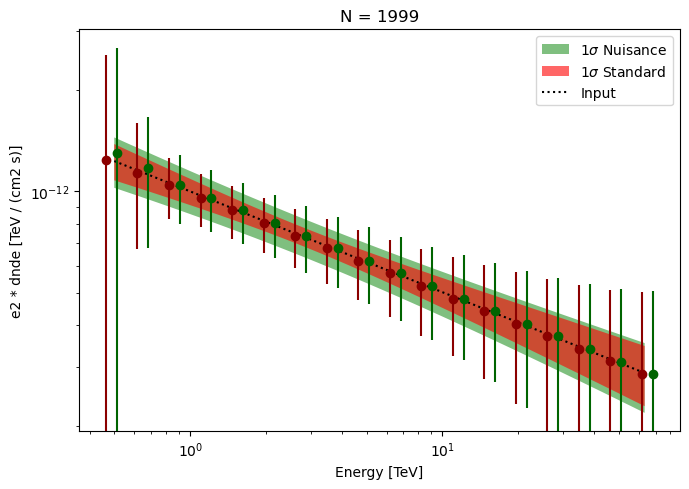

In [121]:
fig, axs = plt.subplots(1,1, figsize = (7,5))
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Nuisance", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "$1\sigma$ Standard", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )




e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 0.95)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o')  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.05)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o')  


axs.legend()
axs.set_title(f"N = {N}")
plt.tight_layout()


In [122]:
mask2 = fluxpoints[0].ts.data[:,0,0].data > 4
mask2

fluxpoints[0].ts.data[:,0,0].mask = mask2

In [123]:

e2dnde = []

for f in fluxpoints:
    mask2 = f.ts.data[:,0,0].data > 4
    e2dnde.append(f.e2dnde.data[:,0,0])
e2dnde = np.array(e2dnde)   



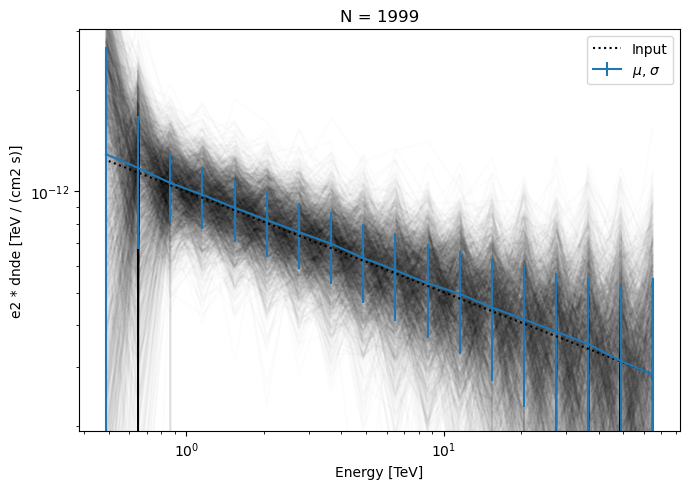

In [124]:
fig, axs1 = plt.subplots(1,1,figsize = (7,5) )
for f,e  in zip(fluxpoints,e2dnde):
    axs1.plot(f.energy_ref* 1.0, e    , color = 'black', alpha = 0.01)
    
axs1.errorbar(f.energy_ref, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
              label = "$\mu$, $\sigma$"
            )

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs1,
                                label = "Input", color = "black", )
ylim = axs.get_ylim()
axs1.set_ylim(ylim[0], ylim[1])
axs1.loglog()
axs1.set_title(f"N = {N}")
axs1.legend()
plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7d_fluxpoints_rnd_{shift}_{N}." + picformat)


In [125]:
def fraction_within_e(lower_lim, upper_lim, data):
    withine = []
    for ie in range(len(lower_lim)):
        xs = []
        for f in data:
            value = f[ie]   
            lowerlim = (np.all(value >= lower_lim[ie]))
            upperlim = (np.all(value <= upper_lim[ie]))
            x = lowerlim & upperlim
            xs.append(x)
        withine.append(np.count_nonzero(xs) / len(data))
    withine  = np.array(withine)
    return withine[withine>0] 

In [126]:
e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.05)
within_e = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 1.05)
within_eN = fraction_within_e(f_-ferr_ , f_ + ferr_, e2dnde)
within_eN


array([0.67683842, 0.68584292, 0.68934467, 0.68334167, 0.66733367,
       0.66133067, 0.68734367, 0.68484242, 0.67733867, 0.68234117,
       0.68434217, 0.68434217, 0.66833417, 0.65832916, 0.67083542,
       0.67733867, 0.69534767, 0.66433217])

In [127]:
def compute_precision(N):
    Z = 1.645
    return  Z / np.sqrt(N)
p = compute_precision(N)

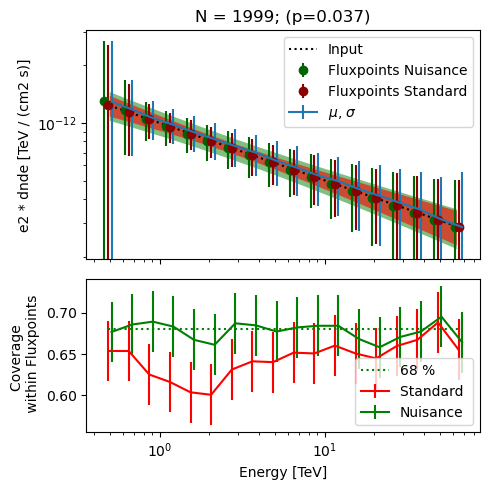

In [128]:
fig, (axs, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 2]},
                         sharex = True, figsize = ((5,5)))

dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = "green", alpha = 0.5)    
    
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs,
                                label = "", facecolor = "red", alpha = 0.6)

dataset_standard.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov_N, 0.95)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkgreen', fmt='o', label = "Fluxpoints Nuisance")  

e_, f_, ferr_ = plot_shifted(fluxpoints_asimov, 1.0)
axs.errorbar(e_, f_, yerr = ferr_, color = 'darkred', fmt='o', label = "Fluxpoints Standard")  



axs.errorbar(f.energy_ref* 1.05, e2dnde.mean(axis = 0), yerr = e2dnde.std(axis=0) , 
                 label = "$\mu$, $\sigma$")


ax2.errorbar(ebins, within_e, yerr=p,color = 'red', label = f"Standard ")
ax2.errorbar(ebins*1.05, within_eN,yerr=p, color = 'green', label = "Nuisance")
ax2.plot(ebins, [0.68] * len(ebins), ':', color = 'green', label = "68 %")

axs.set_xlabel('')
axs.legend()
ax2.legend()
axs.set_title(f"N = {N}; (p={p:.2})")
ax2.set_xlabel('Energy [TeV]')
ax2.set_ylabel('Coverage \n within Fluxpoints')

axs.set_xlabel('')
axs.legend()

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7d_fluxpoints_coverage_{shift}_{N}." + picformat)
